In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

#!pip install stellargraph

!pip install networkx
import networkx as nx

!pip install scikit-plot
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/MyDrive')
from inductiveGRL.graphconstruction import GraphConstruction
from inductiveGRL.hinsage import HinSAGE_Representation_Learner_Nrecentfast_Filter, HinSAGE_Representation_Learner_Nrecentfast
import stellargraph as sg

from inductiveGRL.evaluation import Evaluation

from xgboost import XGBClassifier

!pip install shap
import shap 
#shap.initjs()


# 1. Read in data 

Read in the data and split it into training and test datasets.

In [ ]:
data_full = pd.read_csv('/content/drive/MyDrive/AI Dissertation /data/bs140513_032310.csv')
data_full["index"] = data_full.index
# add a column to data for customer id and merchant id with prefix 1: C and 2: M
data_full['merchant_id'] = data_full['merchant'].str.replace("M", '2').str.replace("'", "")
data_full['customer_id'] = data_full['customer'].str.replace("C", '1').str.replace("'", "")
data_full['category'] = data_full['category'].str.replace("'", "")
data_full['age'] = data_full['age'].str.replace("'", "")

category_oh = pd.get_dummies(data_full['category'], prefix='category')
data_full = data_full.join(category_oh)

age_oh = pd.get_dummies(data_full['age'], prefix='age')
data_full = data_full.join(age_oh)

def split_data(data, split_start, split_end):
    return data.loc[(data['step'] >= split_start) & (data['step'] <= split_end)]

data_train = split_data(data_full.loc[data_full["category"] != "es_transportation"], 0, 140)
data_test = split_data(data_full.loc[data_full["category"] != "es_transportation"], 141, 180)
inductive_graph_data = pd.concat((data_train, data_test))

## 1.2 Form the Graph

In [ ]:
def data_to_graph(dataset):
  ### nodes
  #node_customers = pd.DataFrame([1]*len(dataset.customer_id.unique())).set_index(dataset.customer_id.unique())
  node_customers = dataset[["step", "customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"]).set_index("customer_id")
  #print(node_customers.loc["1369566106"])
  node_merchants = dataset[["step", "merchant_id"]].drop_duplicates(subset=["merchant_id"]).set_index("merchant_id")
  # node_merchants = pd.DataFrame([1]*len(dataset.merchant_id.unique())).set_index(dataset.merchant_id.drop_duplicates())

  # transaction node data
  node_txns = dataset[["step", "amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", 
                       "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", 
                       "category_es_travel", "category_es_wellnessandbeauty", "index"]]

  ### edges
  # customer to transaction edges
  edge_customer = dataset[["customer_id", "index"]]

  # transaction to merchant edges
  edge_merchant = dataset[["index", "merchant_id"]]

  nodes = {"customer":dataset.customer_id, "merchant":dataset.merchant_id, "transaction":dataset.index}
  edges = [zip(edge_customer.customer_id, edge_customer.index), zip(edge_merchant.index, edge_merchant.merchant_id)]
  features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}

  graph = GraphConstruction(nodes, edges, features)
  S = graph.get_stellargraph()
  return S

S = data_to_graph(data_train)
#print(S.info())

## Inductive graph data is train + test data
#inductive_graph_data = pd.concat((data_train, data_test))
#S_ind = data_to_graph(inductive_graph_data)
#print(S_ind.info())

## 1.3 Function that trains and evaluates GraphSAGE for Time window

In [ ]:
def train_and_evaluate(start_train_time_step, end_train_time_step, start_test_time_step, end_test_time_step, epochs=1):
  #data_train = split_data(data_full.loc[data_full["category"] != "es_transportation"], start_train_time_step, end_train_time_step)
  #data_test = split_data(data_full.loc[data_full["category"] != "es_transportation"], start_test_time_step, end_test_time_step)
  data_train = split_data(data_full, start_train_time_step, end_train_time_step)
  data_test = split_data(data_full, start_test_time_step, end_test_time_step)

  S = data_to_graph(data_train)

  ## Inductive graph data is train + test data
  inductive_graph_data = pd.concat((data_train, data_test))
  S_ind = data_to_graph(inductive_graph_data)

  trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(data_train.index), data_train['fraud'], batch_size=5, epochs=epochs, start_time=start_train_time_step, end_time=end_train_time_step)
  
  inductive_emb = hinsage.inductive_step_hinsage(S_ind, trained_hinsage_model, data_test.index, batch_size=5, start_time=start_test_time_step, end_time=end_test_time_step)
  train_labels = data_train['fraud']

  add_additional_data = True

  classifier = XGBClassifier(n_estimators=100)
  base_classifier = XGBClassifier(n_estimators=100)

  if add_additional_data is True:
      train_emb_m = pd.merge(train_emb, data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)
      inductive_emb_m = pd.merge(inductive_emb, data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)

      baseline_train = data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]
      baseline_inductive = data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]

      base_classifier.fit(baseline_train, train_labels)
      baseline_predictions = base_classifier.predict_proba(baseline_inductive)

      classifier.fit(train_emb_m, train_labels)
      predictions = classifier.predict_proba(inductive_emb_m)
      
  else:
    classifier.fit(train_emb, train_labels)
    predictions = classifier.predict_proba(inductive_emb)

  inductive_labels = data_full.loc[inductive_emb.index]['fraud']

  graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
  graphsage_evaluation.pr_curve()

  if add_additional_data is True:
      baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
      baseline_evaluation.pr_curve()
      plt.show()
  train_emb_m.columns = train_emb_m.columns.astype('str')

  explainer = shap.TreeExplainer(classifier)
  base_explainer = shap.TreeExplainer(base_classifier)

  base_shap_values = base_explainer(baseline_train)
  shap_values = explainer(train_emb_m)

  shap.plots.bar(shap_values, max_display=19)
  shap.plots.bar(base_shap_values, max_display=19)
  
  return inductive_labels, baseline_predictions, predictions, inductive_emb, train_emb_m, base_classifier, classifier, baseline_train


## 1.4 True positive overlap analysis function

In [ ]:
def tp_overlap_analysis(labels, baseline_predictions, graph_predictions, txn_data):
  baseline_tp = []
  graph_tp = []
  # get a list of baseline true positives and of graph true positives
  i=0
  for index, value in labels.items():
    # baseline true positives
    if value == baseline_predictions[i] and value == 1:
      baseline_tp.append(index)
    # graph true positives
    if value == graph_predictions[i] and value == 1:
      graph_tp.append(index)
    i = i+1 
  
  # compare id's from besline to graph true positives
  both_count = 0
  both_value = 0
  baseline_only_count = 0
  baseline_only_value = 0
  baseline_only_indexes = []
  for baseline_index in baseline_tp:
    if baseline_index in graph_tp:
      both_count += 1
      both_value += txn_data.loc[baseline_index, "amount"]
    else:
      baseline_only_count += 1
      baseline_only_value += txn_data.loc[baseline_index, "amount"]
      baseline_only_indexes.append(baseline_index)
  graph_only_count = 0
  graph_only_value = 0
  graph_only_indexes = []
  graph_both_count = 0
  for graph_index in graph_tp:
    if graph_index in baseline_tp:
      graph_both_count += 1
    else:
      graph_only_count += 1
      graph_only_value += txn_data.loc[graph_index, "amount"]
      graph_only_indexes.append(graph_index)
  
  print("Number of overlapping transactions:", both_count)
  print("Number of baseline only transactions:", baseline_only_count)
  print("Number of GraphSAGE+features only transactions:", graph_only_count)
  print()
  total_TPs = both_count+baseline_only_count+graph_only_count
  print("Total number of TP transactions identified:", total_TPs)
  print("Percentage of overlapping transactions:", 100*both_count/total_TPs)
  print("Percentage of baseline only transactions:", 100*baseline_only_count/total_TPs)
  print("Percentage of GraphSAGE+Features only transactions:", 100*graph_only_count/total_TPs)
  print()
  print("Value of overlapping transactions:", both_value)
  print("Value of baseline only transactions:", baseline_only_value)
  print("Value of GraphSAGE+features transactions:", graph_only_value)
  print()
  total_value = both_value+baseline_only_value+graph_only_value
  print("% Value of overlapping transactions:", 100*both_value/total_value)
  print("% Value of baseline only transactions:", 100*baseline_only_value/total_value)
  print("% Value of GraphSAGE+features transactions:", 100*graph_only_value/total_value)
  print()
  print("Average Value of overlapping transactions:", both_value/both_count)
  print("Average Value of baseline only transactions:", baseline_only_value/baseline_only_count)
  print("Average Value of GraphSAGE+features transactions:", graph_only_value/graph_only_count)
  
  return both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes



# 2.1 NRecentfast Experiment 1


The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/3
72070/72070 [==============================] - 2851s 40ms/step - loss: 0.0386 - val_loss: 0.0332
Epoch 2/3
72070/72070 [==============================] - 2837s 39ms/step - loss: 0.0256 - val_loss: 0.0268
Epoch 3/3
28842/28842 [==============================] - 1135s 39ms/step
Average precision-recall score XGBoost: 0.9064934755
Average precision-recall score XGBoost: 0.7933957870


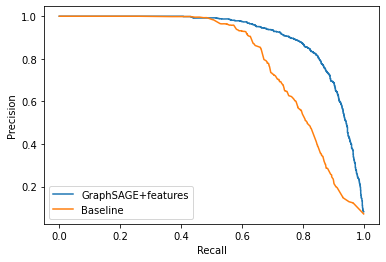

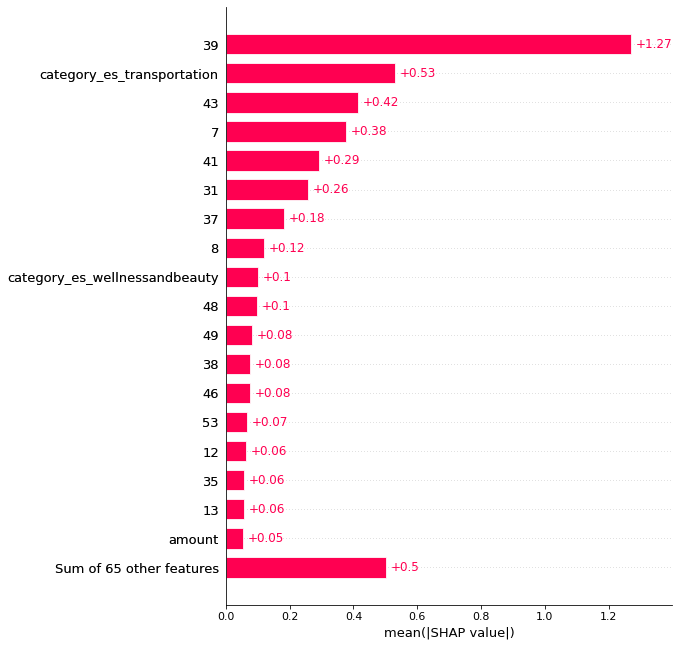

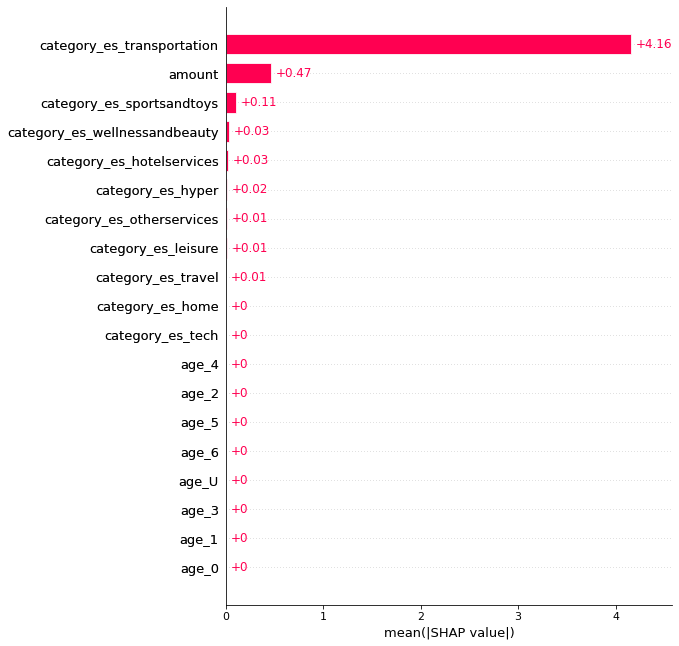

Number of overlapping transactions: 923
Number of baseline only transactions: 18
Number of GraphSAGE+features only transactions: 226

Total number of TP transactions identified: 1167
Percentage of overlapping transactions: 79.0916880891174
Percentage of baseline only transactions: 1.5424164524421593
Percentage of GraphSAGE+Features only transactions: 19.365895458440445

Value of overlapping transactions: 721985.5499999995
Value of baseline only transactions: 4930.73
Value of GraphSAGE+features transactions: 38196.33

% Value of overlapping transactions: 94.36330555315249
% Value of baseline only transactions: 0.6444450052914438
% Value of GraphSAGE+features transactions: 4.992249441556065

Average Value of overlapping transactions: 782.216197183098
Average Value of baseline only transactions: 273.9294444444444
Average Value of GraphSAGE+features transactions: 169.01030973451327


The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/3
72070/72070 [==============================] - 3027s 42ms/step - loss: 0.0391 - val_loss: 0.0462
Epoch 2/3
72070/72070 [==============================] - 2899s 40ms/step - loss: 0.0263 - val_loss: 0.0404
Epoch 3/3
72070/72070 [==============================] - 2775s 39ms/step - loss: 0.0229 - val_loss: 0.0216


In [ ]:
num_samples = [2, 32]
embedding_node_type = "transaction"
n_runs = 1

for i in range(n_runs):
  hinsage = HinSAGE_Representation_Learner_Nrecentfast_Filter(embedding_size=64, num_samples=num_samples, embedding_for_node_type=embedding_node_type, S=S, batch_size=5, start_time=0, end_time=6)

  inductive_labels, baseline_predictions, predictions, inductive_emb, train_emb_m, base_classifier, classifier, baseline_train = train_and_evaluate(start_train_time_step=0, end_train_time_step=140, 
                                                                          start_test_time_step=141, end_test_time_step=180, epochs=3)

  both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes = tp_overlap_analysis(inductive_labels, np.argmax(baseline_predictions, axis=1), np.argmax(predictions, axis=1), inductive_graph_data)
